## Torch neural-network for classific images by anymal

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim 
import torch.utils.tensorboard as tensorboadr
import torchvision
import torchvision.transforms as transforms


#### set default device (CUDA or CPU)

In [2]:
def_dev = torch.get_default_device()
if torch.cuda.is_available():
    print("GPU avail ")
    torch.set_default_device('cuda')
else:
    print("Only CPU")
    torch.set_default_device('cpu')

print(def_dev, " =====>>> ", torch.get_default_device())

GPU avail 
cpu  =====>>>  cuda:0


In [3]:
path_to_img = "/mnt/yankey/dataset/train/"
path_to_train_csv = "/mnt/yankey/dataset/train.csv"

In [4]:
train_csv = pd.read_csv(path_to_train_csv)
train_csv['unified_class'].unique()

array(['Оленевые', 'Кошки', 'Заяц', 'Полорогие', 'Пантеры', 'Медведь',
       'Кабан', 'Куньи', 'Сурок', 'Собачие'], dtype=object)

In [5]:
transforma = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(size=(32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

batch_size = 4 

In [6]:
from pathlib import Path

data_path = Path(path_to_img)

image_path_list = list(data_path.glob("*.JPG"))

{'class_name': 'Собачие', 'class_id': 8}


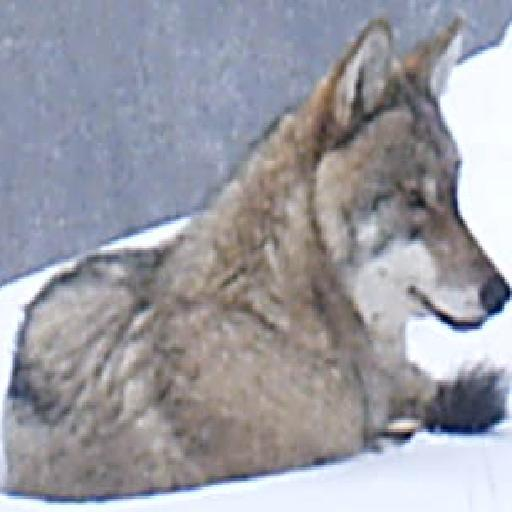

In [7]:
import random
from PIL import Image


def get_image_class(image_name):
    result = train_csv[train_csv["image_name"] == image_name]
    return {'class_name':result['unified_class'].values[0], 'class_id':int(result['class_id'].values[0])}


random.seed(random.randrange(1, 1000))

random_image = random.choice(image_path_list)

img = Image.open(random_image)
print(get_image_class(random_image.name))
img

In [8]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
    """Plots a series of random images from image_paths.

    Will open n image paths from image_paths, transform them
    with transform and plot them side by side.

    Args:
        image_paths (list): List of target image paths. 
        transform (PyTorch Transforms): Transforms to apply to images.
        n (int, optional): Number of images to plot. Defaults to 3.
        seed (int, optional): Random seed for the random generator. Defaults to 42.
    """
    random.seed(random.randrange(1, 1000))
    random_image_paths = random.sample(list(data_path.glob("*.JPG")), k=n)
    for image_path in random_image_paths:
        print(image_path)
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

#plot_transformed_images(image_path_list, 
#                        transform=transforma, 
#                        n=3)

### create dataset

In [9]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import os

In [13]:
pasd = pd.read_csv(path_to_train_csv)
pasd.iloc[1]['class_id']

np.int64(2)

In [14]:
class AnymalDataset(Dataset):
    """ Anymal classification dataset """

    def __init__(self, root_dir, csv_path, transform=None):
        """Arguments:
            csv_path (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = root_dir
        self.classes = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        """Return mun images in dataset"""

        return len(self.classes)
    
    def __getitem__(self, index):
        """
        Args:
            idx (int): Индекс элемента в датасете.

        Returns:
            tuple: (изображение, метка)
        """
        image_name = self.classes.iloc[index]['image_name']
        image_path = os.path.join(self.image_dir, image_name)
        image = read_image(image_path)
        label = self.classes.iloc[index]['class_id']

        if self.transform:
            image = self.transform(image)

        return image, label

In [15]:
dataset = AnymalDataset(path_to_img, path_to_train_csv, transform=transforma)

In [17]:
image, label = dataset[0]
print(image, label)

tensor([[[0.7961, 0.8941, 0.9373,  ..., 0.9686, 0.9725, 0.9686],
         [0.8902, 0.9059, 0.9569,  ..., 0.9725, 0.9725, 0.9725],
         [0.9569, 0.9569, 0.9608,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9725, 0.9725],
         [0.9647, 0.9765, 0.9804,  ..., 0.9686, 0.9725, 0.9725],
         [0.9608, 0.9765, 0.9765,  ..., 0.9765, 0.9804, 0.9804]],

        [[0.7961, 0.8941, 0.9373,  ..., 0.9686, 0.9725, 0.9686],
         [0.8902, 0.9059, 0.9569,  ..., 0.9725, 0.9725, 0.9725],
         [0.9569, 0.9569, 0.9608,  ..., 0.9765, 0.9765, 0.9765],
         ...,
         [0.9843, 0.9843, 0.9843,  ..., 0.9686, 0.9725, 0.9725],
         [0.9647, 0.9765, 0.9804,  ..., 0.9686, 0.9725, 0.9725],
         [0.9608, 0.9765, 0.9765,  ..., 0.9765, 0.9804, 0.9804]],

        [[0.7961, 0.8941, 0.9373,  ..., 0.9686, 0.9725, 0.9686],
         [0.8902, 0.9059, 0.9569,  ..., 0.9725, 0.9725, 0.9725],
         [0.9569, 0.9569, 0.9608,  ..., 0.9765, 0.9765, 0.

In [18]:
trainloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=0, generator=torch.Generator(device='cuda'),)

In [19]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))

<class 'torch.Tensor'>


## Neural network

In [20]:
import torch.nn as nn
import torch.nn.functional as F

In [21]:
l1 = 64
l2 = 128
l3 = 256

class Net(nn.Module):
        def __init__(self):
            super(Net, self).__init__()


            # input channel, output filter, kernel size
            self.conv1 = nn.Conv2d(3, l1, 5, padding=2)
            self.conv2 = nn.Conv2d(l1, l2, 5, padding=2)
            self.conv3 = nn.Conv2d(l2, l3, 3)

            self.BatchNorm2d1 = nn.BatchNorm2d(l1)
            self.BatchNorm2d2 = nn.BatchNorm2d(l2)
            self.BatchNorm2d3 = nn.BatchNorm2d(l3)

            self.BatchNorm2d4 = nn.BatchNorm2d(120)



            self.pool = nn.MaxPool2d(2, 2)
            self.dropout = nn.Dropout(p=0)

            self.fc1 = nn.Linear(l3 * 3 * 3, 120)
            self.fc2 = nn.Linear(120, 84)
            self.fc3 = nn.Linear(84, 10)

        def forward(self, x):
            x = self.BatchNorm2d1(self.pool(F.leaky_relu(self.conv1(x))))
            x = self.BatchNorm2d2(self.pool(F.leaky_relu(self.conv2(x))))
            x = self.BatchNorm2d3(self.pool(F.leaky_relu(self.conv3(x))))
            x = x.view(x.size(0), l3 * 3 * 3)
            x = self.dropout(F.leaky_relu(self.fc1(x)))
            x = self.dropout(F.leaky_relu(self.fc2(x)))
            #x = self.dropout(F.leaky_relu(self.fc4(x)))
            x = self.fc3(x)
            return x


In [22]:
net = Net()
net = net.to('cuda:0')
print(net)

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (BatchNorm2d1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [24]:
for epoch in range(5):

    running_loss = 0.0

    for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to('cuda:0'), labels.to('cuda:0')
                optimizer.zero_grad()

                outputs = net(inputs)
                loss = criterion(outputs, labels)

                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                if i % 2000 == 1999:
                    print('[%d, %5d] loss: %.3f' %
                          (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0
print('Finished Training')

[1,  2000] loss: 1.578
[1,  4000] loss: 1.341
[1,  6000] loss: 1.250
[2,  2000] loss: 1.118
[2,  4000] loss: 1.092
[2,  6000] loss: 1.046
[3,  2000] loss: 0.924
[3,  4000] loss: 0.915
[3,  6000] loss: 0.880
[4,  2000] loss: 0.791
[4,  4000] loss: 0.807
[4,  6000] loss: 0.782
[5,  2000] loss: 0.703
[5,  4000] loss: 0.706
[5,  6000] loss: 0.708
Finished Training


In [58]:
net = Net()
net.load_state_dict(torch.load("./network.pth", weights_only=True))

<All keys matched successfully>

In [25]:
torch.save(net.state_dict(), "./network.pth")

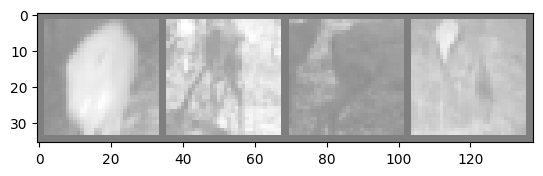

GroundTruth:  Сурок Медведь Медведь Медведь


In [59]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
images_g, labels_g = inputs.cpu().cuda(), labels.cpu().cuda()

classes = ('Оленевые', 'Кошки', 'Заяц', 'Полорогие', 'Пантеры', 'Медведь',
       'Кабан', 'Куньи', 'Сурок', 'Собачие')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]}' for j in range(4)))

In [60]:
outputs = net(images_g)

In [61]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(3)))

Predicted:  Медведь Кабан Сурок


In [118]:
correct = 0
total = 0
with torch.no_grad():
    for data in trainloader:
                images, labels = data
                images, labels = images.to("cuda:0"), labels.to('cuda:0')
                print(images.size())
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
torch.Size([4, 3, 32, 32])
t

KeyboardInterrupt: 

In [77]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
            for data in trainloader:
                images, labels = data
                images, labels = images.to("cuda:0"), labels.to("cuda:0")
                outputs = net(images)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == labels).squeeze()
                for i in range(3):
                    label = labels[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

for i in range(10):
            print('Accuracy of %5s : %2d %%' % (
                classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of Оленевые : 75 %
Accuracy of Кошки : 76 %
Accuracy of  Заяц : 39 %
Accuracy of Полорогие : 56 %
Accuracy of Пантеры : 85 %
Accuracy of Медведь : 91 %
Accuracy of Кабан : 77 %
Accuracy of Куньи : 73 %
Accuracy of Сурок : 48 %
Accuracy of Собачие : 78 %


In [136]:
path_casv = '/mnt/yankey/dataset/sample_submission.csv'
form = pd.read_csv('/mnt/yankey/dataset/sample_submission.csv')
path_to_test = '/mnt/yankey/dataset/test/'
form.head()

,image_name,predicted_class
0,cc27b9b56583a615fb8501e352402eb9.JPG,0
1,87872711fe672676fd34a97e997f9c47.JPG,0
2,424aa1aa8eb5bbdd07275f88077bc86c.JPG,0
3,c5537eaa60525efd7bad4a5560607e83.JPG,0
4,e9f15b67ca49453e281b2b4f245eac13.JPG,0


In [137]:
class AnymalDataset_Test(Dataset):
    """ Anymal classification dataset """

    def __init__(self, root_dir, csv_path, transform=None):
        """Arguments:
            csv_path (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.image_dir = root_dir
        self.classes = pd.read_csv(csv_path)
        self.transform = transform
    
    def __len__(self):
        """Return mun images in dataset"""

        return len(self.classes)
    
    def __getitem__(self, index):
        """
        Args:
            idx (int): Индекс элемента в датасете.

        Returns:
            tuple: (изображение, метка)
        """
        image_name = self.classes.iloc[index]['image_name']
        image_path = os.path.join(self.image_dir, image_name)
        image = read_image(image_path)

        if self.transform:
            image = self.transform(image)

        return image, image_name

In [141]:
dataset = AnymalDataset_Test(path_to_test, path_casv, transform=transforma)
testloader = torch.utils.data.DataLoader(dataset, batch_size=1,
                                          shuffle=True, num_workers=0, generator=torch.Generator(device='cuda'),)

In [176]:
net = Net()
net.load_state_dict(torch.load('network.pth', weights_only=True))
net.to("cuda:0")

Net(
  (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (BatchNorm2d1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BatchNorm2d4): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0, inplace=False)
  (fc1): Linear(in_features=2304, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
def update_class(img, classid):
    form.loc[form['image_name'] == img, 'predicted_class'] = classid

In [209]:

for data in testloader:
        image, image_name = data
        image = image.cuda()
        with torch.no_grad():
            outputs = net(image)
            _, pred = torch.max(outputs, 1)
            form.loc[form['image_name'] == image_name[0], 'predicted_class'] = pred[0].item()
        
    #print(testloader[id][0].size())

In [211]:
form['predicted_class'].unique()
form.to_csv('m.csv')

KeyError: "None of [Index(['image_name', 'predicted_class'], dtype='object')] are in the [columns]"

In [132]:
form['predicted_class'] = 

In [4]:
import math

In [57]:
K1 = 3
M = 2
K2 = 2
P2 = 2
N2 = 1

In [58]:
NK = math.ceil(K2 / N2)
total_F = M * NK
P1 = math.ceil(K1 / total_F)
F1 = math.ceil((K1 - total_F)/NK)
print(P1, F1)

1 0


In [64]:
def main(K1, M, K2, P2, N2):
    total_flatZ_at_flor = math.ceil(K2 / N2)
    total_flat_in_house = M * total_flatZ_at_flor
    if K1 < total_flat_in_house:
        P1 = 1
        N1 = 0
    else:
        P1 = math.ceil(K1 / total_flat_in_house)
        N1 = K1 - total_flat_in_house*(P1-1)
        N1 = math.ceil(N1 / total_flatZ_at_flor)
    return (P1, N1)

In [65]:
print(main(K1, M, K2, P2, N2))

(1, 0)
